In [1]:
import math
from matplotlib import pyplot
import numpy
from scipy.sparse import csr_matrix, coo_matrix
import scipy.sparse.linalg as splinalg

import pyibm

from helper import plot_contourf, circle, print_stats, taylor_green_vortex, get_sub_field

%matplotlib inline

In [2]:
pyplot.rc('font', family='serif', size=14)

In [3]:
pyibm.__version__

'0.1'

In [4]:
# Set configuration parameters of computational grid.
xstart, xend, nx = 0.0, 1.0, 100
ystart, yend, ny = 0.0, 1.0, 100
config = dict(x=dict(start=xstart, end=xend, num_cells=nx),
              y=dict(start=ystart, end=yend, num_cells=ny))
dx, dy = (xend - xstart) / nx, (yend - ystart) / ny
# Create staggered grids.
grid = pyibm.GridBase(config=config)  # vertex grid
gridc = pyibm.GridCellCentered(grid=grid)  # cell-centered grid
gridx = pyibm.GridFaceX(grid=grid)  # x-face centered grid
gridy = pyibm.GridFaceY(grid=grid)  # y-face centered grid
print(gridc)
print(gridx)
print(gridy)

Grid(size=10000, shape=(100, 100), gridlines=[
Gridline(start=0.0, end=1.0, size=100),
Gridline(start=0.0, end=1.0, size=100)])
Grid(size=9900, shape=(100, 99), gridlines=[
Gridline(start=0.0, end=1.0, size=99),
Gridline(start=0.0, end=1.0, size=100)])
Grid(size=9900, shape=(99, 100), gridlines=[
Gridline(start=0.0, end=1.0, size=100),
Gridline(start=0.0, end=1.0, size=99)])


In [5]:
def get_initial_conditions(gridx, gridy, body, t, nu):
    """Taylor-Green vortex at time t."""
    # Compute initial Eulerian solution.
    u, _, _ = taylor_green_vortex(gridx.x.vertices, gridx.y.vertices,
                                  t, nu)
    _, v, _ = taylor_green_vortex(gridy.x.vertices, gridy.y.vertices,
                                  t, nu)
    vel = numpy.concatenate([u.flatten(), v.flatten()])
    # Compute initial Lagrangian solution.
    u_B, v_B, _ = taylor_green_vortex(body.x, body.y, t, nu, dim=1)
    vel_B = numpy.empty(u_B.size + v_B.size, dtype=u_B.dtype)
    vel_B[::body.ndim], vel_B[1::body.ndim] = u_B, v_B
    return vel, vel_B

In [6]:
# Create immersed body.
offset_x, offset_y = 0.0, 0.0
R, center = 0.25, (0.5 + offset_x, 0.5 + offset_y)
body = pyibm.Body(*circle(R=R, center=center, ds=dx), grid=gridc)
print(body)

Body(ndim=2, size=158)


In [7]:
# Set parameters.
Re = 100.0
nu = 1 / Re
t = 0.0

vel, vel_B = get_initial_conditions(gridx, gridy, body, t, nu)

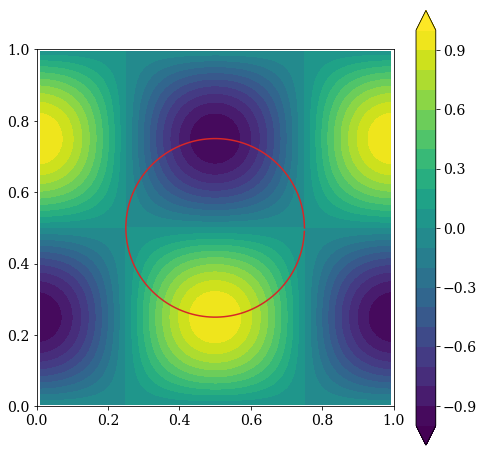

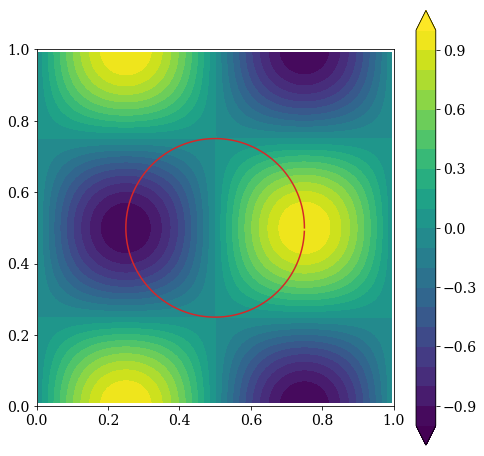

In [8]:
u = vel[:gridx.size].reshape(gridx.shape)
v = vel[gridx.size:].reshape(gridy.shape)
levels = numpy.linspace(-1.0, 1.0, num=21)
body_plot_kwargs = dict(color='C3')
axis_lim = (xstart, xend, ystart, yend)
plot_contourf(u, gridx, body=body, body_plot_kwargs=body_plot_kwargs,
              levels=levels, axis_lim=axis_lim)
plot_contourf(v, gridy, body=body, body_plot_kwargs=body_plot_kwargs,
              levels=levels, axis_lim=axis_lim);

In [9]:
def assemble_operators(gridx, gridy, gridc, body,
                       dt=1.0, Re=100.0, N=1):
    """Assemble operators."""
    # Assemble the divergence operator.
    DHat = pyibm.assemble_DHat(gridc, gridx, gridy)
    # Create the Laplacian operator.
    LHat = pyibm.assemble_LHat(gridx, gridy)
    # Assemble the approximate inverse of the velocity operator.
    a_I = 0.5  # implicit coefficient from Crank-Nicolson scheme
    BN = pyibm.assemble_BN(gridx, gridy, dt=dt, alpha=a_I / Re,
                           N=N, L=LHat)
    # Create the scaling diagonal matrix MHat.
    MHat = pyibm.assemble_MHat(gridx, gridy)
    # Create the scaling diagonal matrix R.
    R = pyibm.assemble_R(gridx, gridy)
    # Assemble delta kernel operator.
    kernel = pyibm.delta_roma_et_al_1999
    kernel_size = 2
    Op = pyibm.assemble_delta(body, gridc, gridx, gridy,
                              kernel=kernel, kernel_size=kernel_size)
    # Create the interpolation operator (as implemented in PetIBM).
    EHat = Op @ R @ MHat
    # Create the speading operator (as implemented in PetIBM).
    HHat = csr_matrix(Op.T)
    # Create the LHS operator of the system for the Lagrangian forces.
    EBNH = EHat @ BN @ HHat
    return DHat, BN, EHat, HHat, EBNH

In [10]:
DHat, BN, EHat, HHat, EBNH = assemble_operators(gridx, gridy, gridc,
                                                body, N=1,
                                                dt=0.001, Re=100.0)

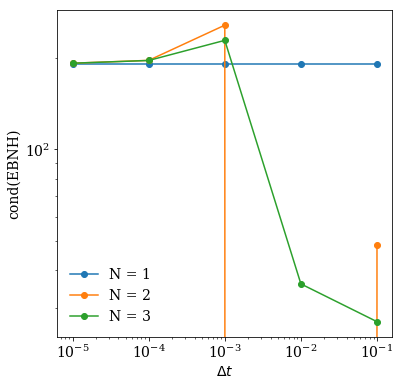

In [11]:
# Compute the condition number of EBNH for different N and dt.
dt_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
N_values = [1, 2, 3]
cond = []
for N in N_values:
    cond_N = []
    for dt in dt_values:
        _, _, _, _, EBNH_t = assemble_operators(gridx, gridy, gridc,
                                                body, N=N, dt=dt, Re=100.0)
        cond_N.append(pyibm.condition_number(EBNH_t)[-1])
    cond.append(cond_N)

# Plot the condition number of EBNH versus the time-step size.
fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('cond(EBNH)')
for i, cond_N in enumerate(cond):
    ax.loglog(dt_values, cond_N, label=f'N = {i + 1}', marker='o')
ax.legend(frameon=False);

(0.026497008211161178, 5.094938840351621, 192.28355140130537)

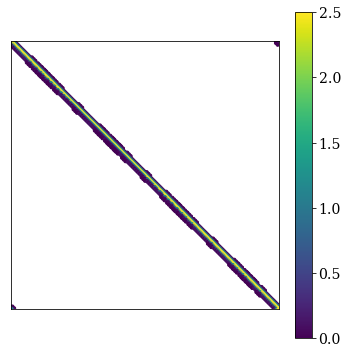

In [12]:
# Plot the non-zero structure of the operator.
pyibm.plot_matrix(EBNH, cmap='viridis', markersize=10)
pyibm.condition_number(EBNH)

In [13]:
# compute the divergence of the velocity field.
div = DHat @ vel
print_stats(div)

Mean: -1.214306433183765e-21
Min, Max: -0.009995065603657325, 0.009995065603657325
L_inf: 0.009995065603657325
L_2: 0.14141856558235663


In [14]:
# Check the divergence of the velocity is zero in sub region.
_, div_box = get_sub_field(div, gridc, box=(0.25, 0.75, 0.25, 0.75))
print_stats(div_box)

Mean: -7.756111291418178e-21
Min, Max: -8.673617379884035e-18, 8.659291346614698e-18
L_inf: 8.673617379884035e-18
L_2: 1.162593525730247e-16


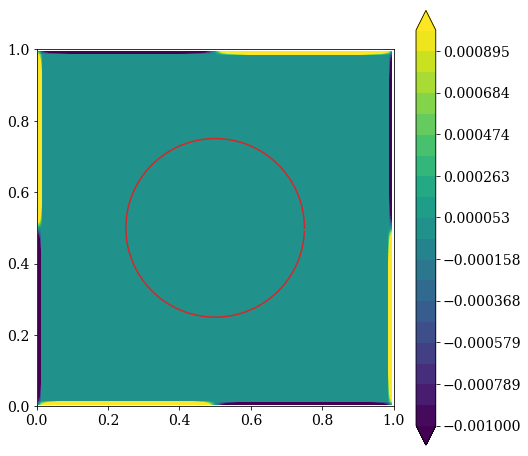

In [15]:
plot_contourf(div, gridc, body=body, body_plot_kwargs=body_plot_kwargs,
              levels=numpy.linspace(-0.001, 0.001, num=20), axis_lim=axis_lim);

In [16]:
# Assemble the right-hand side of the Lagrangian system.
rhsf = vel_B - EHat @ vel
print_stats(rhsf)

Mean: 2.613064476471393e-18
Min, Max: -0.0012480628068246569, 0.0012480628068246569
L_inf: 0.0012480628068246569
L_2: 0.011956026729052292


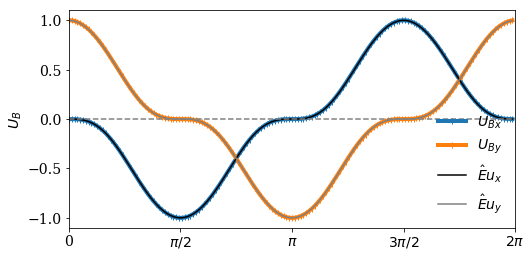

In [17]:
# Plot the value of the RHS along the surface of the body.
U_B_x, U_B_y = vel_B[::body.ndim], vel_B[1::body.ndim]
EHat_vel_x, EHat_vel_y = (EHat @ vel)[::body.ndim], (EHat @ vel)[1::body.ndim]
theta = numpy.linspace(0.0, 2 * numpy.pi, num=body.size + 1)[:-1]

fig, ax = pyplot.subplots(figsize=(8.0, 4.0))
ax.set_ylabel('$U_B$')
ax.plot(theta, U_B_x, label=r'${U_B}_x$', color='C0', linewidth=4.0, marker='|')
ax.plot(theta, U_B_y, label=r'${U_B}_y$', color='C1', linewidth=4.0, marker='|')
ax.plot(theta, EHat_vel_x, label=r'${\hat{E} u}_x$', color='black')
ax.plot(theta, EHat_vel_y, label=r'${\hat{E} u}_y$', color='grey')
ax.axhline(0.0, color='grey', linestyle='--')
ax.legend(frameon=False)
ax.set_xlim(0.0, 2 * numpy.pi)
ax.set_xticks([0.0, numpy.pi / 2, numpy.pi, 3 * numpy.pi / 2, 2 * numpy.pi])
ax.set_xticklabels(['0', r'$\pi / 2$', r'$\pi$', r'$3 \pi / 2$', r'$2 \pi$']);

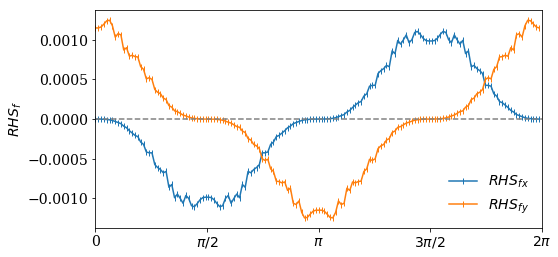

In [18]:
# Plot the value of the RHS along the surface of the body.
rhsf_x, rhsf_y = rhsf[::body.ndim], rhsf[1::body.ndim]
theta = numpy.linspace(0.0, 2 * numpy.pi, num=body.size + 1)[:-1]

fig, ax = pyplot.subplots(figsize=(8.0, 4.0))
ax.set_ylabel('$RHS_f$')
ax.plot(theta, rhsf_x, label=r'${RHS_f}_x$', color='C0', marker='|')
ax.plot(theta, rhsf_y, label=r'${RHS_f}_y$', color='C1', marker='|')
ax.axhline(0.0, color='grey', linestyle='--')
ax.legend(frameon=False)
ax.set_xlim(0.0, 2 * numpy.pi)
ax.set_xticks([0.0, numpy.pi / 2, numpy.pi, 3 * numpy.pi / 2, 2 * numpy.pi])
ax.set_xticklabels(['0', r'$\pi / 2$', r'$\pi$', r'$3 \pi / 2$', r'$2 \pi$']);

In [19]:
# Solve the Lagrangian system with a direct solver.
df = splinalg.spsolve(EBNH, rhsf)
print_stats(df)

Mean: 6.862039066363952e-19
Min, Max: -0.000295160197227291, 0.000295160197226738
L_inf: 0.000295160197227291
L_2: 0.0025088614260058454


In [20]:
def distance_to_neighbor(body, grid):
    """Compute directional distances markers / fluid points."""
    xb, yb = body.x, body.y
    x, y = grid.x.vertices, grid.y.vertices
    dx, dy = numpy.empty(body.size), numpy.empty(body.size)
    for k, (xb_k, yb_k) in enumerate(zip(body.x, body.y)):
        i = numpy.argmin(numpy.abs(x - xb_k))
        j = numpy.argmin(numpy.abs(y - yb_k))
        dx[k], dy[k] = xb_k - x[i], yb_k - y[j]
    return dx, dy

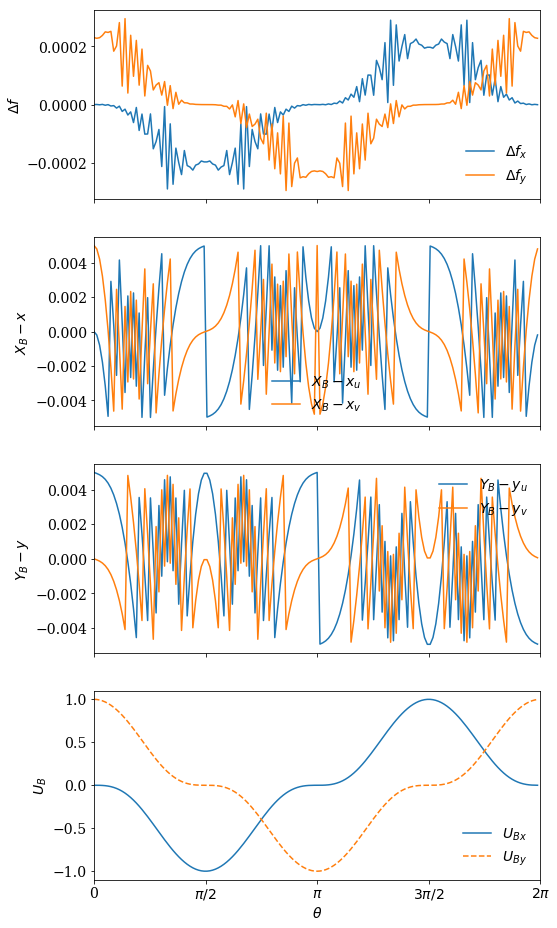

In [21]:
# Plot the magnitude of the Lagragian forces over the surface of the body.
df_x, df_y = df[::body.ndim], df[1::body.ndim]
theta = numpy.linspace(0.0, 2 * numpy.pi, num=body.size + 1)[:-1]

dx_x, dy_x = distance_to_neighbor(body, gridx)
dx_y, dy_y = distance_to_neighbor(body, gridy)

u_B, v_B = vel_B[::body.ndim], vel_B[1::body.ndim]

fig, ax = pyplot.subplots(nrows=4, sharex=True, figsize=(8.0, 16.0))
ax[0].set_ylabel(r'$\Delta f$')
ax[0].plot(theta, df_x, label=r'${\Delta f}_x$', color='C0')
ax[0].plot(theta, df_y, label=r'${\Delta f}_y$', color='C1')
ax[0].legend(frameon=False)
ax[0].set_xlim(0.0, 2 * numpy.pi)

ax[1].set_ylabel('$X_B - x$')
ax[1].plot(theta, dx_x, label='$X_B - x_u$' , color='C0', linestyle='-')
ax[1].plot(theta, dx_y, label='$X_B - x_v$' , color='C1', linestyle='-')
ax[1].legend(frameon=False)

ax[2].set_ylabel('$Y_B - y$')
ax[2].plot(theta, dy_x, label='$Y_B - y_u$' , color='C0', linestyle='-')
ax[2].plot(theta, dy_y, label='$Y_B - y_v$' , color='C1', linestyle='-')
ax[2].legend(frameon=False)

ax[3].set_xlabel(r'$\theta$')
ax[3].set_ylabel('$U_B$')
ax[3].plot(theta, u_B, label='${U_B}_x$' , color='C0', linestyle='-')
ax[3].plot(theta, v_B, label='${U_B}_y$' , color='C1', linestyle='--')
ax[3].legend(frameon=False)
ax[3].set_xlim(0.0, 2 * numpy.pi)
ax[3].set_xticks([0.0, numpy.pi / 2, numpy.pi, 3 * numpy.pi / 2, 2 * numpy.pi])
ax[3].set_xticklabels(['0', r'$\pi / 2$', r'$\pi$', r'$3 \pi / 2$', r'$2 \pi$']);

In [22]:
# Spread Lagrangian forces to the Eulerian velocity field.
vel += BN @ HHat @ df

# Check that the no-slip condition is satisfied.
print_stats(vel_B - EHat @ vel)

Mean: -8.650189949634027e-18
Min, Max: -3.3306690738754696e-16, 2.220446049250313e-16
L_inf: 3.3306690738754696e-16
L_2: 1.3329058779592028e-15


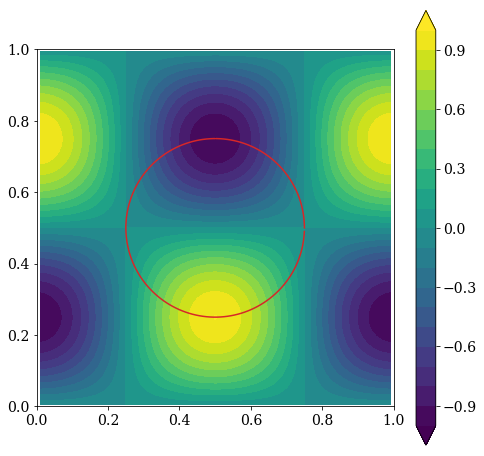

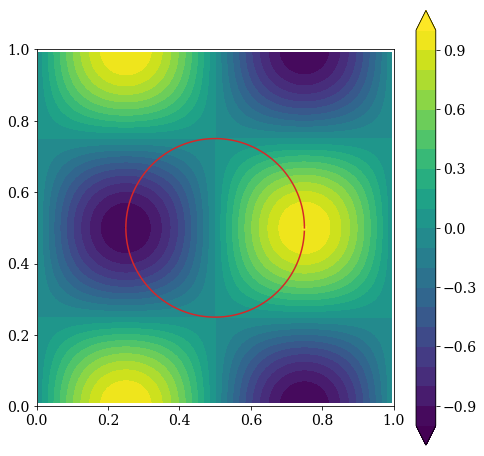

In [23]:
# Plot the filled contours of the velocity components.
u, v = vel[:gridx.size], vel[gridx.size:]
plot_contourf(u, gridx, levels=levels, axis_lim=axis_lim,
              body=body, body_plot_kwargs=dict(color='C3'));
plot_contourf(v, gridy, levels=levels, axis_lim=axis_lim,
              body=body, body_plot_kwargs=dict(color='C3'));

Mean: -4.378143897768028e-21
Min, Max: -7.10148377189258e-06, 7.1014837718967e-06
L_inf: 7.1014837718967e-06
L_2: 5.173852381948783e-05


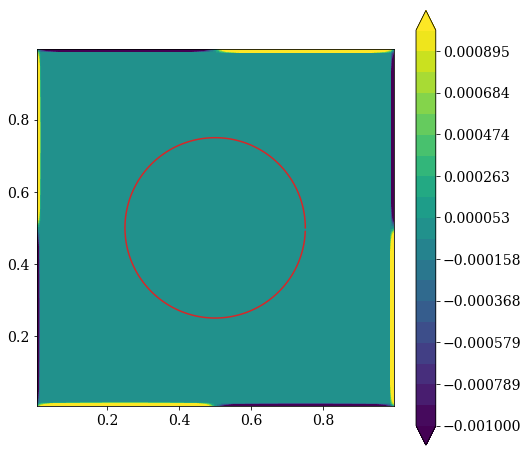

In [24]:
# Compute and plot the divergence of the velocity field.
div = DHat @ vel
_, div_box = get_sub_field(div, gridc, box=(0.25, 0.75, 0.25, 0.75))
print_stats(div_box)
plot_contourf(div,gridc, body=body, body_plot_kwargs=dict(color='C3'),
              levels=numpy.linspace(-0.001, 0.001, num=20));

In [25]:
def analysis(ds_values, N=1, dt=0.01, Re=100.0, verbose=False):
    cond_EBNH = []
    l_inf_div = []
    for ds in ds_values:
        # Create immersed body.
        offset_x, offset_y = 0.0, 0.0
        R, center = 0.25, (0.5 + offset_x, 0.5 + offset_y)
        body = pyibm.Body(*circle(R=R, center=center, ds=ds),
                          grid=gridc)
        # Create initial conditions.
        vel, vel_B = get_initial_conditions(gridx, gridy, body, t, nu)
        # Assemble operators.
        D, BN, E, H, EBNH = assemble_operators(gridx, gridy, gridc, body,
                                               N=N, dt=dt, Re=Re)
        cond = pyibm.condition_number(EBNH)
        cond_EBNH.append(cond[-1])

        # Compute the RHS of the Lagrangian system.
        rhsf = vel_B - E @ vel

        # Solve the Lagrangian system.
        df = splinalg.spsolve(EBNH, rhsf)

        # Spread Lagrangian forces to the Eulerian velocity field.
        vel += BN @ H @ df

        # Compute divergence of the velocity field.
        div = D @ vel
        _, div_box = get_sub_field(div, gridc,
                                   box=(0.25, 0.75, 0.25, 0.75))
        l_inf_div.append(numpy.max(numpy.abs(div_box)))
        
        if verbose:
            print(f'\n*** ds = {ds / dx} * dx')
            print('\n EBNH:')
            print('Symmetric:', pyibm.is_symmetric(EBNH))
            print('Condition number:', cond)
            print('\n Lagrangian forces:')
            print_stats(df)
            # Check that the no-slip condition is satisfied.
            print('\n No-slip condition:')
            print_stats(vel_B - E @ vel)
            print('\n Divergence:')
            print_stats(div_box)
    
    return cond_EBNH, l_inf_div

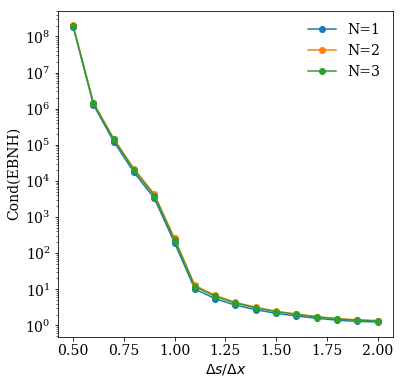

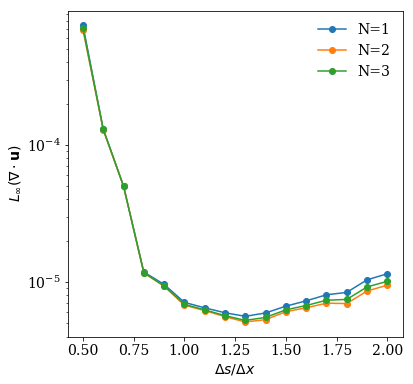

In [26]:
ratios = numpy.arange(0.5, 2.0 + 0.1, 0.1)
ds_values = ratios * dx
cond_EBNH1, l_inf_div1 = analysis(ds_values, N=1, dt=0.001, Re=100.0)
cond_EBNH2, l_inf_div2 = analysis(ds_values, N=2, dt=0.001, Re=100.0)
cond_EBNH3, l_inf_div3 = analysis(ds_values, N=3, dt=0.001, Re=100.0)

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel('Cond(EBNH)')
ax.semilogy(ratios, cond_EBNH1, label='N=1', marker='o')
ax.semilogy(ratios, cond_EBNH2, label='N=2', marker='o')
ax.semilogy(ratios, cond_EBNH3, label='N=3', marker='o')
ax.legend(frameon=False);

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel(r'$L_\infty (\nabla \cdot \mathbf{u})$')
ax.semilogy(ratios, l_inf_div1, label='N=1', marker='o')
ax.semilogy(ratios, l_inf_div2, label='N=2', marker='o')
ax.semilogy(ratios, l_inf_div3, label='N=3', marker='o')
ax.legend(frameon=False);

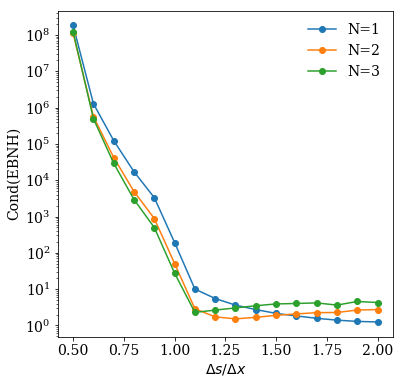

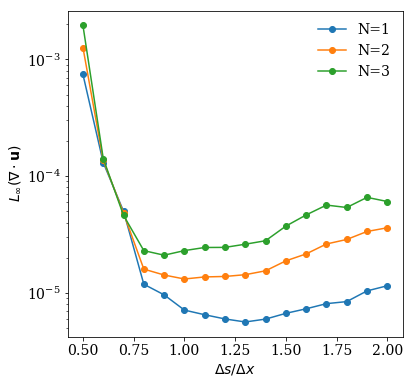

In [27]:
ratios = numpy.arange(0.5, 2.0 + 0.1, 0.1)
ds_values = ratios * dx
cond_EBNH1, l_inf_div1 = analysis(ds_values, N=1, dt=1.0, Re=1.0)
cond_EBNH2, l_inf_div2 = analysis(ds_values, N=2, dt=1.0, Re=1.0)
cond_EBNH3, l_inf_div3 = analysis(ds_values, N=3, dt=1.0, Re=1.0)

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel('Cond(EBNH)')
ax.semilogy(ratios, cond_EBNH1, label='N=1', marker='o')
ax.semilogy(ratios, cond_EBNH2, label='N=2', marker='o')
ax.semilogy(ratios, cond_EBNH3, label='N=3', marker='o')
ax.legend(frameon=False);

fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
ax.set_xlabel(r'$\Delta s / \Delta x$')
ax.set_ylabel(r'$L_\infty (\nabla \cdot \mathbf{u})$')
ax.semilogy(ratios, l_inf_div1, label='N=1', marker='o')
ax.semilogy(ratios, l_inf_div2, label='N=2', marker='o')
ax.semilogy(ratios, l_inf_div3, label='N=3', marker='o')
ax.legend(frameon=False);